# Automatic differentiation

*Selected Topics in Mathematical Optimization*

**Michiel Stock** ([email](michiel.stock@ugent.be))

![](Figures/logo.png)

In [1]:
using Plots, BenchmarkTools

## Definition of a derivative

$$
\frac{\text{d}f(x)}{\text{d}x} = f'(x) = \lim _{h\to 0}{\frac {f(x+h)-f(x)}{h}}.
$$

When we work with function of several variables, we use *partial derivatives* (e.g. $\frac{\partial f(x, y)}{\partial x}$), indicating we keep all variables but $x$ fixed.

Our running example:

$$
f(x) = \log x + \frac{\sin x}{x}
$$

In [2]:
f(x) = log(x) + sin(x) / x

f (generic function with 1 method)

## Symbolic differentiation

Computing derivatives as you have seen in basic calculus courses. 

By hand or automatically:
- Maple
- Sympy (python)
- Mathematica
- Maxima

Differentiation is *easy* compared to *integration* or *sampling*.

Advantages:
- exact derivatives!
- gives the formula for different evaluations.
- no hyperparameters or tweaking: just works!

Disadvantages:
- some software not flexible enough (gradients, arrays, for-loops...)
- sometimes explosion of terms: *expression swell*
- not always numerically optimal!

In [3]:
using SymEngine

In [4]:
@vars x  # define variable

(x,)

In [5]:
df = diff(f(x), x)

-sin(x)/x^2 + cos(x)/x + x^(-1)

In [6]:
df(2.0)

0.0646022250200084

## Numerical differentiation

Finite difference approximation of the derivative/gradient based on a number of function evaluations.

Often based on the limit definition of a derivative. Theoretical analysis using Taylor approximation:

$$
f(x + h) = f(x) + \frac{h}{1!}f'(x) + \frac{h^2}{2!}f''(x) + \frac{h^3}{3!}f^{(3)}(x)+\ldots
$$

**Divided difference**

$$
f'(x)\approx \frac{f(x+h) - f(x)}{h}
$$


**Center difference**

$$
f'(x)\approx \frac{f(x+h) - f(x-h)}{2h}
$$


**Complex step method**

$$
f'(x)\approx \frac{\text{Im} (f(x +ih))}{h}
$$

Some simple implementations:

In [7]:
diff_divdiff(f, x; h=1e-10) = (f(x + h) - f(x)) / h
diff_centdiff(f, x; h=1e-10) = (f(x + h) - f(x - h)) / 2h 
diff_complstep(f, x; h=1e-10) = imag(f(x + im * h)) / h

diff_complstep (generic function with 1 method)

In [8]:
@btime diff_divdiff($f, 2.0)

  5.959 ns (0 allocations: 0 bytes)


0.06460165735688861

In [9]:
@btime diff_centdiff($f, 2.0)

  5.980 ns (0 allocations: 0 bytes)


0.06460165735688861

In [10]:
@btime diff_complstep($f, 2.0)

  73.075 ns (0 allocations: 0 bytes)


0.06460222502000833

**First sin of numerical analysis**:

> *thou shalt not add small numbers to big numbers*

**second sin of numerical analysis**:

> *thou shalt not subtract numbers which are approximately equal*

In [11]:
stepsizes = map(t->10.0^t, -20:0.1:-1);

In [12]:
fexamp(x) = 64x*(1-x)*(1-2x)^2*(1-8x+8x^2)^2
dfexamp = diff(fexamp(x), x)
error(diff, h; x=1.0) = max(abs(Float64(dfexamp(x)) - diff(fexamp, x, h=h)), 1e-50);

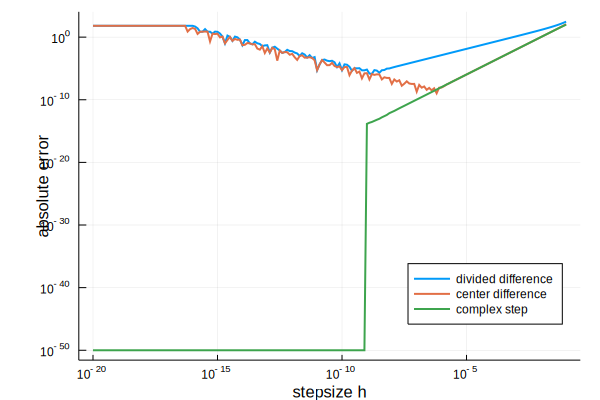

In [13]:
plot(stepsizes, error.(diff_divdiff, stepsizes), label="divided difference",
    xscale=:log10, yscale=:log10, lw=2, legend=:bottomright)
plot!(stepsizes, error.(diff_centdiff, stepsizes), label="center difference", lw=2)
plot!(stepsizes, error.(diff_complstep, stepsizes), label="complex step", lw=2)
#xlims!(1e-15, 1e-1)
xlabel!("stepsize h")
ylabel!("absolute error")

Advantages of numerical differentiation:
- easy to implement
- general, no assumptions needed

Disadvantages:
- not numerically stable (round-off errors)
- not efficient for gradients ($\mathcal{O}(n)$ evaluations for $n$-dimensional vectors)

### Stein's lemma

$$
E_{X\sim N(\mu, \sigma)}[f(X)(X-\mu)] = \sigma^2 E_{X\sim N(\mu, \sigma)}[f'(X)]
$$

and thus, using $X = x + \sigma\epsilon$ with $\epsilon\sim N(0, 1)$:

$$
E_{\epsilon\sim N(0, 1)}[f'(x + \sigma\epsilon)] = \frac{1}{\sigma} E_{\epsilon\sim N(0, 1)}[f(x+\sigma \epsilon)\epsilon]
$$

In [14]:
diff_stein(f, x; σ=1e-2, n=10_000) = 1 / σ * sum(map(e -> f(x + σ * e) * e, randn(n))) / n

diff_stein (generic function with 1 method)

In [15]:
@btime diff_stein($f, 2.0)

  199.217 μs (6 allocations: 156.45 KiB)


-0.27217206448529696

### Approximations of multiplications with gradients

**Gradient-vector approximation**

$$
\nabla f(\mathbf{x})^\intercal \mathbf{d} \approx \frac{f(\mathbf{x}+h\cdot\mathbf{d}) - f(\mathbf{x}-h\cdot\mathbf{d})}{2h}
$$

**Hessian-vector approximation**

$$
\nabla^2 f(\mathbf{x}) \mathbf{d} \approx \frac{\nabla f(\mathbf{x}+h\cdot\mathbf{d}) - \nabla f(\mathbf{x}-h\cdot\mathbf{d})}{2h}
$$

In [16]:
grad_vect(f, x, d; h=1e-10) = (f(x + h * d) - f(x - h * d)) / (2h)

grad_vect (generic function with 1 method)

In [17]:
dvect = randn(10) / 10
xvect = 2rand(10)

A = randn(10, 10)
A = A * A' / 100

#g(x) = exp(- x' * A * x)  # adjoint does not play with Zygote
g(x) = exp(- sum(x .* (A * x)))

# correct gradient and Hessian (by hand)
∇g(x) = -2g(x) * A * x
∇²g(x) = -2g(x) * A - 2A * x * ∇g(x)'

∇²g (generic function with 1 method)

In [18]:
g(xvect)

0.23149375435928718

In [19]:
∇g(xvect)

10-element Array{Float64,1}:
 -0.047270343850100205
 -0.003152847935003064
 -0.015051765159728205
 -0.13112942708566533 
 -0.045786035129939   
 -0.04169867154398666 
 -0.09505324433164841 
 -0.11917229849859608 
  0.006547793500320991
  0.01260491352661311 

In [20]:
∇g(xvect)' * dvect

-0.014674907368256622

In [21]:
grad_vect(g, xvect, dvect)

-0.014674511605861085

In [22]:
∇²g(xvect) * dvect

10-element Array{Float64,1}:
  0.0019404488971407272
  0.0008475529147466098
  0.007035138265761713 
  0.003255957282159906 
  0.0025283825031831584
  0.0012847575582729065
  0.005247333372321636 
  0.004332177421950171 
  0.0035726442951524856
 -0.00127925317107779  

In [23]:
h = 1e-10
(∇g(xvect + h * dvect) - ∇g(xvect - h * dvect)) / (2h)

10-element Array{Float64,1}:
  0.0019403922912886173
  0.0008475165014232289
  0.007035205751293461 
  0.0032555902418351934
  0.0025282900772971573
  0.0012847015118389038
  0.005247191570134646 
  0.004331951464209283 
  0.003572662998774234 
 -0.0012792111120374372

## Forward differentiation

Accumulation of the gradients along the *computational graph*. 

<img src="Figures/compgraph.png" alt="drawing" width="400"/>

Forward differentiation computes the gradient from the inputs to the outputs.

### Differentiation rules

**Sum rule**:

$$
\frac{\partial (f(x)+g(x))}{\partial x} =  \frac{\partial f(x)}{\partial x} + \frac{\partial f(x)}{\partial x} 
$$

**Product rule**:

$$
\frac{\partial (f(x)g(x))}{\partial x} =  f(x)\frac{\partial g(x)}{\partial x} + g(x)\frac{\partial f(x)}{\partial x} 
$$

**Chain rule**:

$$
\frac{\partial (g(f(x))}{\partial x} =  \frac{\partial g(u)}{\partial u}\mid_{u=f(x)} \frac{\partial f(x)}{\partial x} 
$$

### Example of the forward differentiation

<img src="Figures/forwarddiff.png" alt="drawing" width="600"/>

### Dual numbers

Forward differentiation can be viewed as evaluating function using *dual numbers*, which can be viewed as truncated Taylor series:

$$
v + \dot{v}\epsilon\,,
$$

where $v,\dot{v}\in\mathbb{R}$ and $\epsilon$ a nilpotent number, i.e. $\epsilon^2=0$. For example, we have

$$
(v + \dot{v}\epsilon) + (u + \dot{u}\epsilon) = (v+u) + (\dot{v} +\dot{u})\epsilon
$$


$$
(v + \dot{v}\epsilon)(u + \dot{u}\epsilon) = (vu) + (v\dot{u} +\dot{v}u)\epsilon\,.
$$



These dual numbers can be used as

$$
f(v+\dot{v}\epsilon) = f(v) + f'(v)\dot{v}\epsilon\,.
$$

In [24]:
struct Dual
    v
    v̇
end

In [25]:
Base.:+(a::Dual, b::Dual) = Dual(a.v + b.v, a.v̇ + b.v̇)
Base.:*(a::Dual, b::Dual) = Dual(a.v * b.v, a.v * b.v̇ + b.v * a.v̇)
Base.:*(v::Real, b::Dual) = Dual(v, 0.0) * b
Base.:sin(a::Dual) = Dual(sin(a.v), cos(a.v) * a.v̇)
Base.:log(a::Dual) = Dual(log(a.v), 1.0 / a.v * a.v̇)
Base.:/(a::Dual, b::Dual) = Dual(a.v / b.v, (a.v̇ * b.v - a.v * b.v̇) / b.v^2)

In [26]:
@btime f(Dual(2.0, 1.0))

  57.236 ns (6 allocations: 144 bytes)


Dual(1.1477958939727861, 0.06460222502000834)

In [27]:
myforwarddiff(f, x) = f(Dual(x, 1.0)).v̇

@btime myforwarddiff($f, 2.0)

  57.380 ns (6 allocations: 144 bytes)


0.06460222502000834

This directly works for vectors!

In [28]:
q(x) = 10.0 * x[1] * x[2] + x[1] * x[1] + sin(x[1]) / x[2]

q (generic function with 1 method)

In [29]:
q([1, 2])

21.42073549240395

In [30]:
q(Dual.([1, 2], [1, 0]))  # partial wrt x1

Dual(21.42073549240395, 22.27015115293407)

In [31]:
q(Dual.([1, 2], [0, 1]))  # partial wrt x2

Dual(21.42073549240395, 9.789632253798025)

In [32]:
using ForwardDiff

In [33]:
@btime ForwardDiff.derivative($f, 2.0)

  2.666 ns (0 allocations: 0 bytes)


0.06460222502000834

In [34]:
@btime ForwardDiff.gradient($g, $xvect)

  2.241 μs (10 allocations: 4.23 KiB)


10-element Array{Float64,1}:
 -0.04727034385010022 
 -0.003152847935003066
 -0.015051765159728198
 -0.13112942708566533 
 -0.04578603512993899 
 -0.04169867154398666 
 -0.09505324433164841 
 -0.11917229849859606 
  0.006547793500320994
  0.01260491352661311 

In [35]:
ForwardDiff.gradient(q, [1, 2])

2-element Array{Float64,1}:
 22.27015115293407 
  9.789632253798025

Forward differentiation:

- exact gradients!
- computational complexity scales with **number of inputs**
- used when you have more outputs than inputs

## Reverse differentiation

Compute the gradient from the output toward the inputs using the chain rule.

<img src="Figures/reversediff.png" alt="drawing" width="600"/>

Reverse differentiation:

- also exact!
- main workhorse for training artificial neural networks.
- efficient when more inputs than outputs (machine learning: thousands of parameters vs. one loss)

In [36]:
using Zygote

┌ Info: Recompiling stale cache file /Users/michielstock/.julia/compiled/v1.1/Zygote/4kbLI.ji for Zygote [e88e6eb3-aa80-5325-afca-941959d7151f]
└ @ Base loading.jl:1184


In [37]:
@btime f'(2.0)

  2.667 ns (0 allocations: 0 bytes)


0.06460222502000834

In [38]:
@btime g'(xvect)

  5.936 μs (46 allocations: 3.52 KiB)


10-element Array{Float64,1}:
 -0.04727034385010021  
 -0.0031528479350030666
 -0.015051765159728205 
 -0.13112942708566533  
 -0.045786035129939    
 -0.04169867154398666  
 -0.09505324433164841  
 -0.11917229849859606  
  0.006547793500320997 
  0.01260491352661311  

## Application: deep learning

Multi-layer perceptron.

<img src="Figures/ANN_example.png" alt="drawing" width="200"/>

Reverse differentation or backpropagation.

<img src="Figures/Forwardprop.png" alt="drawing" width="500"/>

Reverse differentation or backpropagation.

<img src="Figures/Backprop.png" alt="drawing" width="500"/>

Returns effect of changing layer output on the loss. Can be related directly to the parameters!

## Exercise: logistic regression

Recall logistic regression on a training set $S=\{(\mathbf{x}_i, y_i)\mid i=1,\ldots,n\}$ with $y\in\{0,1\}$.

Prediction:

$$
f(\mathbf{x}) = \sigma(\mathbf{w}^\intercal\mathbf{x})\,,
$$

with $\sigma(t) = 1 /(1+exp(t))$.

To find the parameter vector $\mathbf{w}$, we minimize the cross-entropy:

$$
L(\mathbf{w};S)= \sum_{i=1}^n = - y_i \log(f(\mathbf{x})) - (1-y_i)\log(1-f(\mathbf{x}))\,.
$$

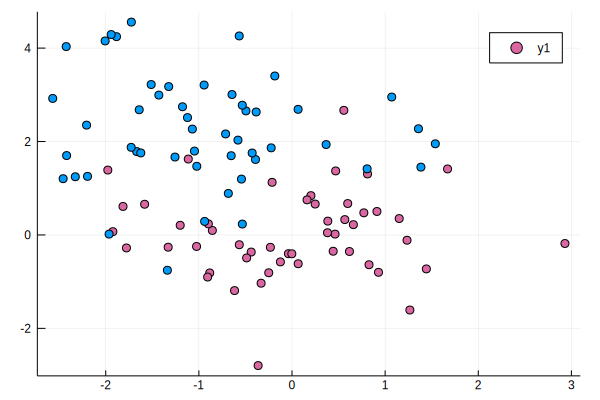

In [39]:
# artificial data
X = [randn(50, 2); randn(50, 2) .+ [-1.0 2.4]];
y = [i <= 50 ? 0 : 1 for i in 1:100];
n = length(y);

scatter(X[:,1], X[:,2], color=y)

In [40]:
σ(t) = 1.0 / (1.0 + exp(t))
f(x, w) = σ(sum(x .* w))
L(w; X=X, y=y) = sum(- y .* log.(σ.(X * w)) - (1.0 .- y) .* log.(σ.(1. .- X * w)))

L (generic function with 1 method)

In [41]:
w = [0.1, 0.1]
L(w)

103.7986865342272

**Assignments**

1. Compute the gradient of $L$ wrt. $\mathbf{w}$ using
    - numerical method
    - forward differentiation
    - backward differentiation
2. (optional) Implement a simple gradient descent to find  $\mathbf{w}^\star$.
3. Add a bias to the prediction function.

## Differentiating ODE

Automatic differentiation can be used beyond machine learning and optimization:

- [physical engines](https://arxiv.org/abs/1611.01652) to learn robot control
- differentiating [protein](https://github.com/lupoglaz/TorchProteinLibrary) [structures](https://www.cell.com/cell-systems/fulltext/S2405-4712(19)30076-6)
- Sinkhorn algorithm
- [dynamic programming](https://arxiv.org/abs/1802.03676)
- [differential equations](https://julialang.org/blog/2019/01/fluxdiffeq)

Everything is computed by some straightforward and differentiable functions!

### Short introduction to differential equations

Ordinary differential equations describe dynamical processes through the *rate of change*:

$$
\dot{\mathbf{x}} = f(\mathbf{x}, t; \theta)\,,
$$

with $\theta$ some parameters. To obtain a unique solution, we depart from some initial vector for $\mathbf{x}$ at the starting time.

Usually solved using an iterative algorithm, for example using Euler's method:

$$
\mathbf{x}_{t+1} = \mathbf{x}_{t} + \alpha_t f(\mathbf{x}_{t}, t)\,.
$$

with $\alpha_t$ a stepsize (does this remind you of something?).

### Example an auto-catalytic process

Consider a chemical reaction where some molecule $X$ combines reversibly with a molecule $A$ to form two molecules $X$:

$$
X+A	\rightleftharpoons 2X\,.
$$

We assume that there is a large and inexhaustible supply of $A$. Based on the *law of mass action* for chemical kinetics, the concentration of $X$ is given by 

$$
\dot{x} = k_1ax - k_{-1} x^2\,,
$$



with
- $x$ the concentration of $X$;
- $a$ the concentration of $A$;
- $k_1$ and $k_{-1}$ the forward and backward kinetic parameters.

In [42]:
function eulersolve(f, x0, (t0, tend), θ, α=0.1)
    tsteps = t0:α:tend
    # demonstration for didactical purposes
    # Any arrays are generally a bad idea!
    sol = Array{Any}(undef, length(tsteps), length(x0))
    x = x0
    for (i, t) in enumerate(tsteps)
        sol[i, :] .= x
        x += α * f(x, t, θ)
    end
    return sol
end

eulersolve (generic function with 2 methods)

In [43]:
fautocat(x, t, (a, k₁, k₋₁)) = k₁ * a * x - k₋₁ * x.^2

fautocat (generic function with 1 method)

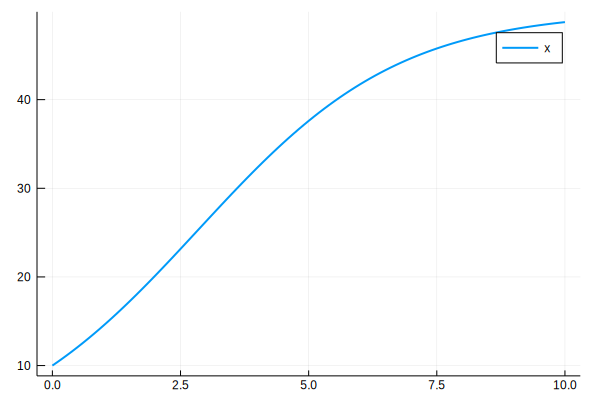

In [44]:
solution = eulersolve(fautocat, [10.0], (0.0, 10.0), (5, 0.1, 0.01))
tsteps = 0:0.1:10
plot(tsteps, solution, label="x", lw=2)

**Assignments**

1. Given $x_0=10$ and $(a, k_1, k_{-1}) = (5, 0.1, 0.01)$, compute the gradient of $x(t)$ w.r.t. $x_0$ (e.g. sensitivity for initial conditions.
2. Given these parameters, use gradient descent to tune $x_0$ such that $x(10) = 20$.
3. Given a vector of measured concentrations with $x_0=10$, find the parameters of the process through gradient descent.

In [45]:
# for the first two questions
xfromx0(x0) = eulersolve(fautocat, x0, (0.0, 10.0), (5, 0.1, 0.01))
x10fromx0(x0) = xfromx0(x0)[end]

x10fromx0 (generic function with 1 method)

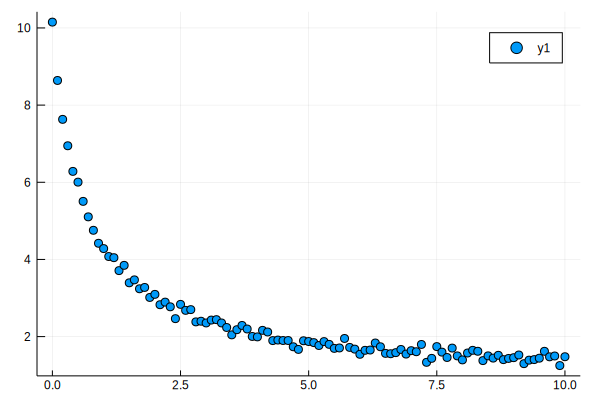

In [46]:
# for the last question
# you only see the measurements
measurements = eulersolve(fautocat, 10.0, (0.0, 10.0), (2.6, 0.07, 0.15))
measurements .+= 0.1 * randn(length(measurements))

scatter(tsteps, measurements)

In [47]:
# function that works with autograd
function squared_error(θ; measurements=measurements, x0=10.0, α=0.1)
    sq_error = 0.0
    x = x0
    for yi in measurements
        sq_error += (yi - x)^2
        x += α * fautocat(x, 0.0, θ)
        
    end
    return sq_error
end

squared_error (generic function with 1 method)

## References

- Gunes et. al. (2015) *Automatic differentiation in machine learning: a survey*